# Deliverable 3: Optimize the Model

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

#Import MatPlotLib for visualizayions
import matplotlib.pyplot as plt

#Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'. Also dropped Special_Considerations
application_df= application_df.drop(["EIN","NAME","SPECIAL_CONSIDERATIONS","STATUS"], axis=1)
application_df.head(5)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,142590,1


In [3]:
# Generate our categorical variable list
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

In [4]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE      17
AFFILIATION            6
CLASSIFICATION        71
USE_CASE               5
ORGANIZATION           4
INCOME_AMT             9
ASK_AMT             8747
IS_SUCCESSFUL          2
dtype: int64

In [5]:
# Look at APPLICATION_TYPE value counts for binning
application_type_counts = application_df.APPLICATION_TYPE.value_counts()
application_type_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

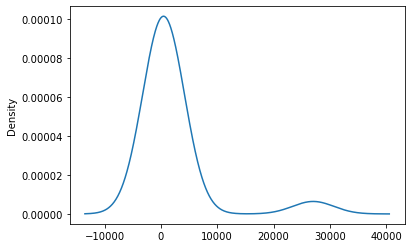

In [6]:
# Visualize the value counts of APPLICATION_TYPE
application_type_counts.plot(kind="density")

In [7]:
# Determine which values to replace if counts are less than 500
replace_application = list(application_type_counts[application_type_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [8]:
# Look at CLASSIFICATION value counts for binning
classification_value_counts = application_df["CLASSIFICATION"].value_counts()
classification_value_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C2170        1
C5200        1
C1370        1
C1728        1
C4200        1
Name: CLASSIFICATION, Length: 71, dtype: int64

<AxesSubplot:ylabel='Density'>

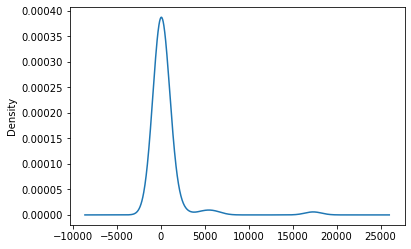

In [9]:
# Visualize the value counts of CLASSIFICATION
classification_value_counts.plot(kind="density")

In [10]:
# Look at ASK_AMT value counts for binning
ASKAMT_counts = application_df["ASK_AMT"].value_counts()
ASKAMT_counts

5000       25398
15583          3
6725           3
63981          3
10478          3
           ...  
75598          1
22336          1
44863          1
5928           1
6948863        1
Name: ASK_AMT, Length: 8747, dtype: int64

<AxesSubplot:ylabel='Density'>

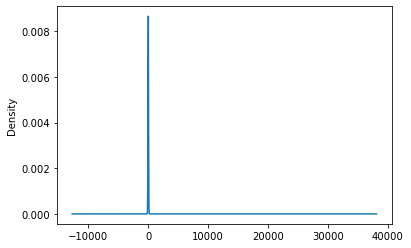

In [11]:
# Visualize the value counts of ASK_AMT
ASKAMT_counts.plot(kind="density")

In [12]:
# Determine which values to replace if counts are less than 100
replace_ask_amt = list(ASKAMT_counts[ASKAMT_counts < 100].index)

# Replace in dataframe
for amt in replace_ask_amt:
    if amt <= 49999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5001-49999"))
    elif amt < 99999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("50000-99999"))
    elif amt < 499999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("100000-499999"))
    elif amt < 999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("500000-999999"))
    elif amt < 4999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("1M-5M"))
    else:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5M+"))
    
application_df.ASK_AMT = application_df.ASK_AMT.astype(str)

# Check to make sure binning was successful
application_df.ASK_AMT.value_counts()

5000             25398
5001-49999        2947
100000-499999     2305
50000-99999       1421
1M-5M              940
500000-999999      651
5M+                637
Name: ASK_AMT, dtype: int64

In [13]:
# Determine which values to replace if counts are less than 1000
replace_class = list(classification_value_counts[classification_value_counts < 1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [14]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'ASK_AMT']

In [15]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,ASK_AMT_100000-499999,ASK_AMT_1M-5M,ASK_AMT_5000,ASK_AMT_50000-99999,ASK_AMT_500000-999999,ASK_AMT_5001-49999,ASK_AMT_5M+
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Merge one-hot encoded features and drop the originals
encoded_application_df = application_df.merge(encode_df, left_index = True, right_index = True).drop(columns = application_cat)
encoded_application_df.head()

,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,...,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,ASK_AMT_100000-499999,ASK_AMT_1M-5M,ASK_AMT_5000,ASK_AMT_50000-99999,ASK_AMT_500000-999999,ASK_AMT_5001-49999,ASK_AMT_5M+
0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Split our preprocessed data into our features and target arrays
y = encoded_application_df.loc[:, "IS_SUCCESSFUL"].values
X = encoded_application_df.drop(columns=["IS_SUCCESSFUL"], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Optimization attempt 1: Compile, Train and Evaluate the Model
## Increase number of hidden layers 

In [19]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

number_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 60
hidden_nodes_layer3 = 40
hidden_nodes_layer4 = 20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                3760      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 11,901
Trainable params: 11,901
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [21]:

# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization1/", exist_ok=True)
checkpoint_path = "checkpoints_optimization1/weights.{epoch:02d}.hdf5"


In [22]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq= 'epoch',
    period=5)

In [23]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5710 - accuracy: 0.7177
Epoch 2/100
804/804 [==============================] - 1s 959us/step - loss: 0.5531 - accuracy: 0.7278
Epoch 3/100
804/804 [==============================] - 1s 905us/step - loss: 0.5497 - accuracy: 0.7303
Epoch 4/100
804/804 [==============================] - 1s 989us/step - loss: 0.5469 - accuracy: 0.7325
Epoch 5/100
769/804 [===========================>..] - ETA: 0s - loss: 0.5455 - accuracy: 0.7339
Epoch 00005: saving model to checkpoints_optimization1\weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5457 - accuracy: 0.7339
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5442 - accuracy: 0.7348
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5431 - accuracy: 0.7344
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5419 - accuracy: 0.7363
Epoch 9/100
804/804 [=========

804/804 [==============================] - 1s 1ms/step - loss: 0.5210 - accuracy: 0.7468
Epoch 63/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5210 - accuracy: 0.7455
Epoch 64/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5214 - accuracy: 0.7450
Epoch 65/100
787/804 [============================>.] - ETA: 0s - loss: 0.5211 - accuracy: 0.7447
Epoch 00065: saving model to checkpoints_optimization1\weights.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5208 - accuracy: 0.7452
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5205 - accuracy: 0.7460
Epoch 67/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5207 - accuracy: 0.7458
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5207 - accuracy: 0.7448
Epoch 69/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5203 - accuracy: 0.7468
Epoch 70/100
789/804 [===================

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 16.3049 - accuracy: 0.5936
Loss: 16.304851531982422, Accuracy: 0.5935860276222229


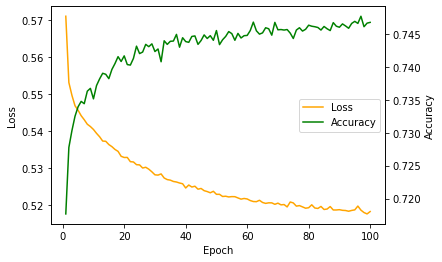

In [25]:
# Visualize Loss/Accuracy
import matplotlib.pyplot as plt
history_df = pd.DataFrame(fit_model.history,
                          index=range(1, len(fit_model.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="orange", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="green", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [26]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_optimization1.h5")

# Optimization attempt 2: Compile, Train and Evaluate the Model

## Keep original hidden layers of 2, but use "sigmoid" as activation function for the hidden layers


In [27]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

number_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="sigmoid"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 80)                3760      
_________________________________________________________________
dense_6 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 6,221
Trainable params: 6,221
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [29]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization2/", exist_ok=True)
checkpoint_path = "checkpoints_optimization2/weights.{epoch:02d}.hdf5"


In [30]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq= 'epoch',
    period=5)

In [31]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.67 - 1s 868us/step - loss: 0.6226 - accuracy: 0.6750
Epoch 2/100
804/804 [==============================] - 1s 894us/step - loss: 0.5772 - accuracy: 0.7203
Epoch 3/100
804/804 [==============================] - 1s 926us/step - loss: 0.5751 - accuracy: 0.7225
Epoch 4/100
804/804 [==============================] - 1s 930us/step - loss: 0.5744 - accuracy: 0.7205
Epoch 5/100
801/804 [============================>.] - ETA: 0s - loss: 0.5734 - accuracy: 0.7214
Epoch 00005: saving model to checkpoints_optimization2\weights.05.hdf5
804/804 [==============================] - 1s 976us/step - loss: 0.5734 - accuracy: 0.7213
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5723 - accuracy: 0.7204
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5709 - accuracy: 0.7226
Epoch 8/100
804/804 [==============================] - 1s 933us/step - loss: 0.5693 -

Epoch 62/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5448 - accuracy: 0.7332
Epoch 63/100
804/804 [==============================] - 1s 974us/step - loss: 0.5444 - accuracy: 0.7331
Epoch 64/100
804/804 [==============================] - 1s 988us/step - loss: 0.5450 - accuracy: 0.7331
Epoch 65/100
794/804 [============================>.] - ETA: 0s - loss: 0.5443 - accuracy: 0.7333
Epoch 00065: saving model to checkpoints_optimization2\weights.65.hdf5
804/804 [==============================] - 1s 975us/step - loss: 0.5441 - accuracy: 0.7332
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5442 - accuracy: 0.7346
Epoch 67/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5444 - accuracy: 0.7343
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5436 - accuracy: 0.7331
Epoch 69/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5437 - accuracy: 0.7334
Epoch 70/100
798/804 [

In [32]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.7602 - accuracy: 0.6252
Loss: 0.7601891756057739, Accuracy: 0.625189483165741


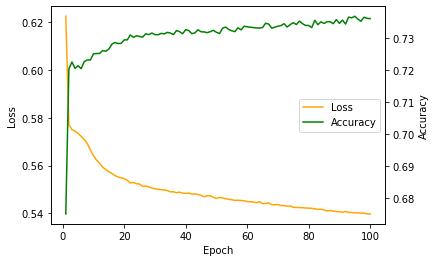

In [33]:
# Visualize Loss/Accuracy
import matplotlib.pyplot as plt
history_df = pd.DataFrame(fit_model.history,
                          index=range(1, len(fit_model.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="orange", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="green", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [34]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_optimization2.h5")

# Optimization attempt 3: Compile, Train and Evaluate the Model¶
## Use 2 hidden layers, more Neurons to first hidden layer and use "relu" as activation function for the hidden layers

In [35]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

number_input_features = len(X_train[0])
hidden_nodes_layer1 = 100
hidden_nodes_layer2 = 40


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               4700      
_________________________________________________________________
dense_9 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 41        
Total params: 8,781
Trainable params: 8,781
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [37]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization3/", exist_ok=True)
checkpoint_path = "checkpoints_optimization3/weights.{epoch:02d}.hdf5"


In [38]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq= 'epoch',
    period=5)

In [39]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 964us/step - loss: 0.5723 - accuracy: 0.7183
Epoch 2/100
804/804 [==============================] - 1s 968us/step - loss: 0.5530 - accuracy: 0.7281
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5493 - accuracy: 0.7303
Epoch 4/100
804/804 [==============================] - 1s 963us/step - loss: 0.5473 - accuracy: 0.7315
Epoch 5/100
786/804 [============================>.] - ETA: 0s - loss: 0.5460 - accuracy: 0.7328
Epoch 00005: saving model to checkpoints_optimization3\weights.05.hdf5
804/804 [==============================] - 1s 988us/step - loss: 0.5460 - accuracy: 0.7327
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5449 - accuracy: 0.7333
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5439 - accuracy: 0.7336
Epoch 8/100
804/804 [==============================] - 1s 981us/step - loss: 0.5428 - accuracy: 0.7361
Epoch 9/100
804/804 [=====

804/804 [==============================] - 1s 1ms/step - loss: 0.5241 - accuracy: 0.7436
Epoch 63/100
804/804 [==============================] - 1s 962us/step - loss: 0.5239 - accuracy: 0.7444
Epoch 64/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5237 - accuracy: 0.7437
Epoch 65/100
799/804 [============================>.] - ETA: 0s - loss: 0.5233 - accuracy: 0.7445
Epoch 00065: saving model to checkpoints_optimization3\weights.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5233 - accuracy: 0.7446
Epoch 66/100
804/804 [==============================] - 1s 966us/step - loss: 0.5233 - accuracy: 0.7451
Epoch 67/100
804/804 [==============================] - 1s 966us/step - loss: 0.5230 - accuracy: 0.7446
Epoch 68/100
804/804 [==============================] - 1s 949us/step - loss: 0.5236 - accuracy: 0.7448
Epoch 69/100
804/804 [==============================] - 1s 962us/step - loss: 0.5233 - accuracy: 0.7451
Epoch 70/100
795/804 [=========

In [40]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 3.9754 - accuracy: 0.6540
Loss: 3.9753589630126953, Accuracy: 0.6539941430091858


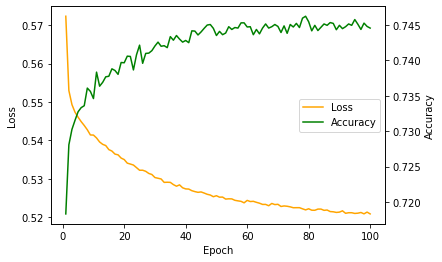

In [41]:
# Visualize Loss/Accuracy
import matplotlib.pyplot as plt
history_df = pd.DataFrame(fit_model.history,
                          index=range(1, len(fit_model.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="orange", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="green", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [42]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_optimization3.h5")

## Attempt 4 - using less neurons, and adding a layer

In [43]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

number_input_features = len(X_train[0])
hidden_nodes_layer1 = 90
hidden_nodes_layer2 = 40
hidden_nodes_layer3 = 15


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 90)                4230      
_________________________________________________________________
dense_12 (Dense)             (None, 40)                3640      
_________________________________________________________________
dense_13 (Dense)             (None, 15)                615       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 16        
Total params: 8,501
Trainable params: 8,501
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [45]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimization4/", exist_ok=True)
checkpoint_path = "checkpoints_optimization4/weights.{epoch:02d}.hdf5"


In [46]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq= 'epoch',
    period=5)

In [47]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5692 - accuracy: 0.7198
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5524 - accuracy: 0.7292
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5494 - accuracy: 0.7310
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5474 - accuracy: 0.7309
Epoch 5/100
764/804 [===========================>..] - ETA: 0s - loss: 0.5463 - accuracy: 0.7327
Epoch 00005: saving model to checkpoints_optimization4\weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5461 - accuracy: 0.7327
Epoch 6/100
804/804 [==============================] - 1s 996us/step - loss: 0.5444 - accuracy: 0.7328
Epoch 7/100
804/804 [==============================] - 1s 997us/step - loss: 0.5435 - accuracy: 0.7341
Epoch 8/100
804/804 [==============================] - 1s 998us/step - loss: 0.5424 - accuracy: 0.7354
Epoch 9/100
804/804 [=========

804/804 [==============================] - 1s 1ms/step - loss: 0.5238 - accuracy: 0.7447
Epoch 63/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5235 - accuracy: 0.7437
Epoch 64/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5234 - accuracy: 0.7438
Epoch 65/100
784/804 [============================>.] - ETA: 0s - loss: 0.5241 - accuracy: 0.7438
Epoch 00065: saving model to checkpoints_optimization4\weights.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5236 - accuracy: 0.7443
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5238 - accuracy: 0.7448
Epoch 67/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5235 - accuracy: 0.7449
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5234 - accuracy: 0.7443
Epoch 69/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5230 - accuracy: 0.7445
Epoch 70/100
779/804 [===================

In [48]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 7.1223 - accuracy: 0.6598
Loss: 7.122345924377441, Accuracy: 0.6598250865936279


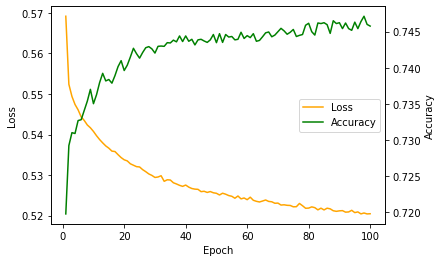

In [49]:
# Visualize Loss/Accuracy
history_df = pd.DataFrame(fit_model.history,
                          index=range(1, len(fit_model.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="orange", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="green", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [50]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_optimization4.h5")